<a href="https://colab.research.google.com/github/Azeem4567/Final_Project_Image_Classification_Cifar10/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing The Libraries

In [2]:
# Import necessary libraries for deep learning, data augmentation, and visualization
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
import cv2  # OpenCV for resizing images
import matplotlib.pyplot as plt
import numpy as np

# Load and Preprocess Data

In [2]:
# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize the images to a range of 0 to 1 for faster and more stable training
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Convert labels to one-hot encoded format for multi-class classification
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


# Data Augmentation Setup

In [3]:
target_size = (64, 64) # target size for resizing
# Function to resize images in the dataset
def resize_images(images, size):
    resized_images = np.array([cv2.resize(img, size) for img in images])
    return resized_images

# Resize train and test images
resized_train_images = resize_images(train_images, target_size)
resized_test_images = resize_images(test_images, target_size)

# Set up data augmentation generator with various transformations
augmentation = ImageDataGenerator(
    rotation_range=10,          # Random rotation up to 20 degrees
    width_shift_range=0.15,     # Horizontal shift by up to 15% of the width
    height_shift_range=0.15,    # Vertical shift by up to 15% of the height
    horizontal_flip=True,       # Randomly flip images horizontally
)
augmentation.fit(resized_train_images)  # Apply augmentation transformations to the training set

# Visualize Augmented Images

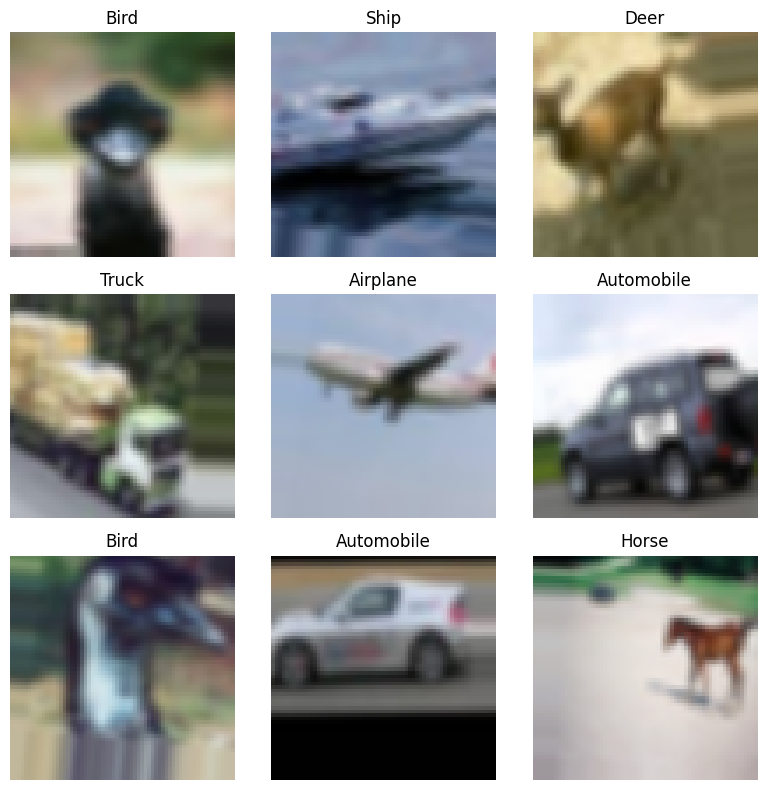

In [4]:
# Display augmented images
# CIFAR-10 class names
class_names = ["Airplane", "Automobile", "Bird", "Cat", "Deer",
               "Dog", "Frog", "Horse", "Ship", "Truck"]

# Display a 3x3 grid of augmented images with class names
plt.figure(figsize=(8, 8))
for batch_images, batch_labels in augmentation.flow(resized_train_images, train_labels, batch_size=9):
    for i in range(9):  # Display the first 9 images in the batch
        plt.subplot(3, 3, i + 1)
        plt.imshow(batch_images[i], interpolation='nearest')
        plt.axis('off')

        # Get the class label for each image
        label_index = np.argmax(batch_labels[i])  # Convert one-hot encoded label to index
        plt.title(class_names[label_index])       # Set the title as the class name

    plt.tight_layout()
    plt.show()
    break  # Display only one batch and exit



# CNN Model With one Conv2D layer Per Block

In [5]:
# Define the model
model = Sequential([
    Input(shape=(target_size[0], target_size[1], 3)),  # Input layer with specified shape

    # Block 1: 1 Conv2D layer + BatchNormalization + MaxPooling + Dropout
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 2: 1 Conv2D layer + BatchNormalization + MaxPooling + Dropout
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Block 3: 1 Conv2D layer + BatchNormalization + MaxPooling + Dropout
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 4: 1 Conv2D layer + BatchNormalization + MaxPooling + Dropout
    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    # Block 5: 1 Conv2D layer + BatchNormalization + MaxPooling + Dropout
    Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    # Fully connected layers with regularization
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.25),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(10, activation='softmax', kernel_regularizer=l2(0.001))  # Output layer
])


# Model Compilation

In [6]:
# Compile the model with an optimizer, loss function, and metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 4, 4, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 512)           │              

 Total params: 2,755,530 (10.51 MB)

 Trainable params: 2,753,546 (10.50 MB)

 Non-trainable params: 1,984 (7.75 KB)

# Training the Model

In [7]:
# Train the model using augmented data
# Define callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),              # Stop training early if no improvement
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)                          # Reduce learning rate on plateau
]

# Train the model using augmented data
history = model.fit(
    augmentation.flow(resized_train_images, train_labels, batch_size=64),  # Training data with augmentation
    epochs=50,
    validation_data=(resized_test_images, test_labels),                    # Validation data
    callbacks=callbacks                                                    # Add callbacks
)

model.save('/content/drive/MyDrive/simple_cnn_model.h5')

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 103s 112ms/step - accuracy: 0.2407 - loss: 3.9064 - val_accuracy: 0.3577 - val_loss: 2.8859 - learning_rate: 0.0010
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 119s 96ms/step - accuracy: 0.4328 - loss: 2.4887 - val_accuracy: 0.4012 - val_loss: 2.4049 - learning_rate: 0.0010
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 74s 94ms/step - accuracy: 0.4984 - loss: 2.0804 - val_accuracy: 0.6194 - val_loss: 1.7831 - learning_rate: 0.0010
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 83s 96ms/step - accuracy: 0.5597 - loss: 1.9823 - val_accuracy: 0.6579 - val_loss: 1.7459 - learning_rate: 0.0010
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 80s 94ms/step - accuracy: 0.5910 - loss: 1.9643 - val_accuracy: 0.5880 - val_loss: 1.9703 - learning_rate: 0.0010
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 73s 93ms/step - accuracy: 0.6167 - loss: 1.9435 - val_accuracy: 0.6828 - val_loss: 1.7433 - learning_rate: 0.0010
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 76s 96ms/step - accuracy: 0.6254 - loss: 1.9

# Plotting the Curves for the Model

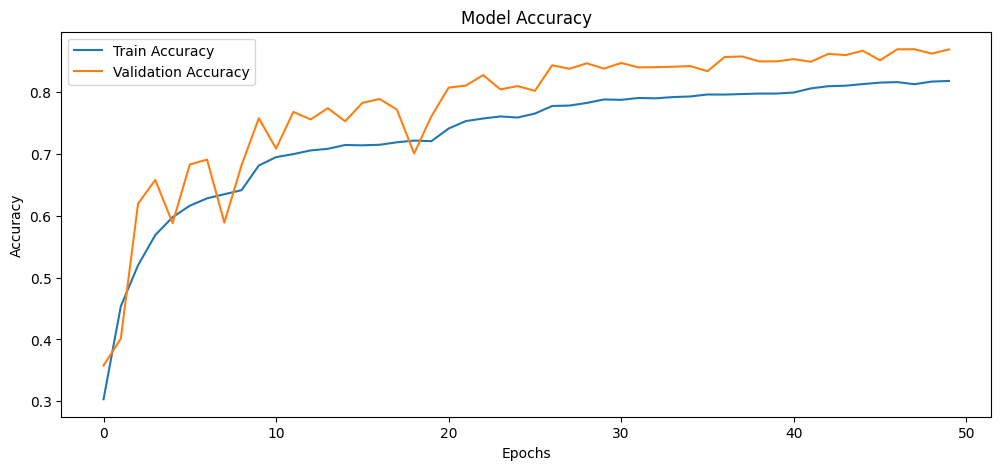

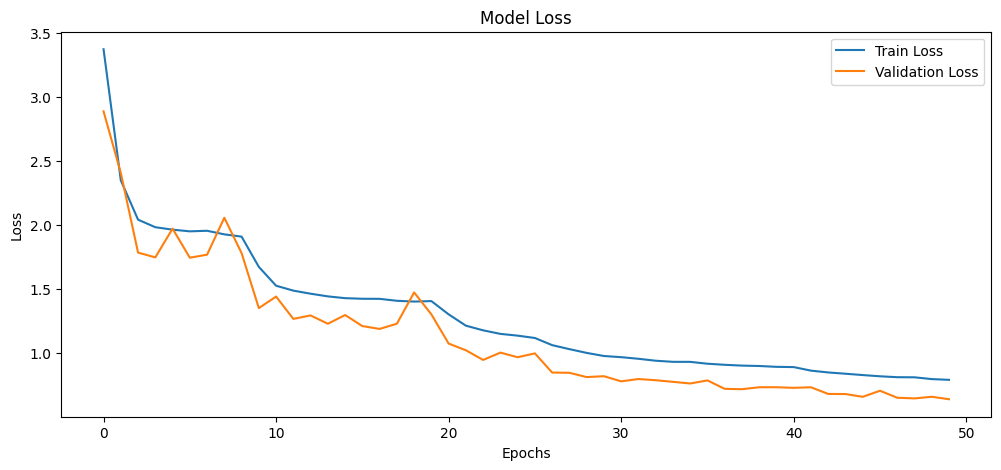

In [8]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Define the CNN Model

In [9]:
# Define the model
model = Sequential([
    Input(shape=(target_size[0], target_size[1], 3)),  # Input layer with specified shape

    # Block 1: 3 Conv2D layers + BatchNormalization + MaxPooling + Dropout
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 2: 3 Conv2D layers + BatchNormalization + MaxPooling + Dropout
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Block 3: 3 Conv2D layers + BatchNormalization + MaxPooling + Dropout
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 4: 3 Conv2D layers + BatchNormalization + MaxPooling + Dropout
    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    # Block 5: 3 Conv2D layers + BatchNormalization + MaxPooling + Dropout
    Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    # Fully connected layers with regularization
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.25),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(10, activation='softmax', kernel_regularizer=l2(0.001))  # Output layer
])

# compiling the Model

In [10]:
# Compile the model with an optimizer, loss function, and metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary

In [11]:
# Print model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 9,046,794 (34.51 MB)

 Trainable params: 9,042,826 (34.50 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [12]:
print(resized_train_images.shape)  # Should match the input shape (e.g., (50000, 64, 64, 3))
print(resized_test_images.shape)
print(type(resized_train_images), type(resized_test_images))
print(train_labels.shape, test_labels.shape)  # Should be (50000, 10) for CIFAR-10

(50000, 64, 64, 3)
(10000, 64, 64, 3)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(50000, 10) (10000, 10)


# Train the Model with Data Augmentation

In [13]:
# Train the model using augmented data
# Define callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),              # Stop training early if no improvement
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)                          # Reduce learning rate on plateau
]

# Train the model using augmented data
history = model.fit(
    augmentation.flow(resized_train_images, train_labels, batch_size=64),  # Training data with augmentation
    epochs=50,
    validation_data=(resized_test_images, test_labels),                    # Validation data
    callbacks=callbacks                                                    # Add callbacks
)

model.save('/content/drive/MyDrive/complex_cnn_model.h5')

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 123s 130ms/step - accuracy: 0.1847 - loss: 5.7012 - val_accuracy: 0.2863 - val_loss: 3.3690 - learning_rate: 0.0010
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 83s 106ms/step - accuracy: 0.3329 - loss: 2.7863 - val_accuracy: 0.3270 - val_loss: 2.2957 - learning_rate: 0.0010
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 143s 108ms/step - accuracy: 0.3879 - loss: 2.0903 - val_accuracy: 0.4000 - val_loss: 2.0181 - learning_rate: 0.0010
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 83s 106ms/step - accuracy: 0.4202 - loss: 1.9259 - val_accuracy: 0.3944 - val_loss: 1.9441 - learning_rate: 0.0010
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 146s 111ms/step - accuracy: 0.4390 - loss: 1.8632 - val_accuracy: 0.4393 - val_loss: 1.8101 - learning_rate: 0.0010
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 90s 114ms/step - accuracy: 0.4831 - loss: 1.8273 - val_accuracy: 0.4206 - val_loss: 2.0077 - learning_rate: 0.0010
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 91s 115ms/step - accuracy: 

# Visualize Training and Validation Performance

In [4]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


NameError: name 'history' is not defined

<Figure size 1200x500 with 0 Axes>

# Evaluating the Model on the Test Set

# Applying the VGG16 Model

In [ ]:
# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Function to resize images to the target size (224x224 for ImageNet models)
def resize_images(images, target_size=(224, 224)):
    """
    Resize input images to the specified target size.
    Args:
        images: Array of input images.
        target_size: Tuple indicating the desired size (height, width).
    Returns:
        Tensor of resized images.
    """
    resized_images = tf.image.resize(images, target_size)  # Resize images
    return resized_images

# Resize CIFAR-10 training and testing images to 224x224
train_images_resized = resize_images(train_images)
test_images_resized = resize_images(test_images)

# Normalize image pixel values to the range [0, 1]
train_images_resized = train_images_resized / 255.0  # Normalize training images
test_images_resized = test_images_resized / 255.0    # Normalize testing images


In [14]:
# Convert labels to one-hot encoding
num_classes = 10
train_labels_onehot = to_categorical(train_labels, num_classes)  # Convert training labels
test_labels_onehot = to_categorical(test_labels, num_classes)    # Convert testing labels

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=15,            # Random rotation range in degrees
    width_shift_range=0.1,        # Random horizontal shift
    height_shift_range=0.1,       # Random vertical shift
    horizontal_flip=True          # Random horizontal flip
)

# Generate augmented training data
train_generator = train_datagen.flow(
    train_images_resized, train_labels_onehot, batch_size=64  # Resized training images and one-hot labels
)

# Validation data generator (only rescaling)
valid_datagen = ImageDataGenerator(rescale=1./255)  # Normalize validation images to [0, 1]


In [ ]:
valid_generator = valid_datagen.flow(
    test_images_resized, test_labels_onehot, batch_size=64  # Resized test images and one-hot labels
)

# Load VGG19 with ImageNet weights and freeze initial layers
base_model = VGG19(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

# Unfreeze the last few layers for fine-tuning
for layer in base_model.layers[:-4]:  # Freeze all but the last 4 layers
    layer.trainable = False

# Add custom top layers
model = Sequential([
    base_model,                           # Pre-trained VGG19 base
    Flatten(),                            # Flatten the feature maps
    Dense(512, activation='relu'),        # Fully connected layer with 512 units
    Dropout(0.5),                         # Dropout to prevent overfitting
    Dense(256, activation='relu'),        # Fully connected layer with 256 units
    Dropout(0.5),                         # Dropout to prevent overfitting
    Dense(10, activation='softmax')       # Output layer for 10 CIFAR-10 classes
])


In [ ]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Train the model using augmented data
# Define callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),              # Stop training early if no improvement
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)                          # Reduce learning rate on plateau
]

# Train the model using augmented data
history = model.fit(
    augmentation.flow(resized_train_images, train_labels, batch_size=64),  # Training data with augmentation
    epochs=50,
    validation_data=(resized_test_images, test_labels),                    # Validation data
    callbacks=callbacks                                                    # Add callbacks
)

model.save('/content/drive/MyDrive/complex_cnn_model.h5')

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
